Matplotlib Exercise: Citi Bike Trips vs. LaGuardia Weather (2022)

In [2]:
# 1. Imports and configuration

import pandas as pd
import os
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

C:\Users\henry\AppData\Local\Temp\ipykernel_17796\1242213817.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
from pathlib import Path
# File paths 
WEATHER_CSV = Path("Data") / "laguardia_2022_weather.csv"
MERGED_CSV = Path("Data") / "citibike_weather_2022.csv"
VIS_DIR = Path("Visualizations")

In [4]:
# Visualization directory 
os.makedirs(VIS_DIR, exist_ok=True)

In [5]:
# 2. Load weather data
weather = pd.read_csv(WEATHER_CSV, parse_dates=["date"])
# Load merged Citi Bike + weather (per-trip) data
trips = pd.read_csv(MERGED_CSV, parse_dates=["started_at", "ended_at", "date"])

In [6]:
# Basic sanity check
print("Weather data range:", weather["date"].min(), "to", weather["date"].max())
print("Total trip records:", len(trips))

Weather data range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00
Total trip records: 786983


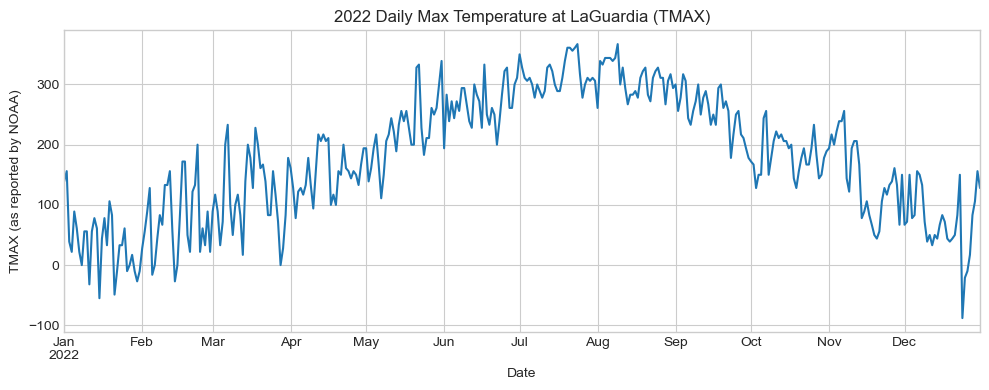

In [7]:
# 3. Plot 2022 daily max temperature time series (pandas quick plot)

# weather data: set index for time series convenience
weather_ts = weather.set_index("date")

# Plot the daily maximum temperature (TMAX)
ax = weather_ts["TMAX"].plot(
    figsize=(10, 4),
    title="2022 Daily Max Temperature at LaGuardia (TMAX)",
    legend=False,
)
ax.set_xlabel("Date")
ax.set_ylabel("TMAX (as reported by NOAA)")
plt.tight_layout()
plt.show()

In [8]:
# Save figure
fig = ax.get_figure()
fig_path = os.path.join(VIS_DIR, "daily_max_temp.png")
fig.savefig(fig_path)
plt.show()
print(f"Saved temperature plot to {fig_path}")

Saved temperature plot to C:\Users\henry\OneDrive\citibike-dashboard-2022\Visualizations\daily_max_temp.png


In [9]:
# 4. Compute daily trip counts and merge with weather

# Aggregate trips per day
daily_trips = (
    trips.groupby(trips["date"].dt.date)
    .size()
    .rename("trips_daily")
    .reset_index()
)
daily_trips["date"] = pd.to_datetime(daily_trips["date"])  # ensure datetime

# Merge with weather (left join on date)
df = pd.merge(weather, daily_trips, on="date", how="left")

# Fill missing trip counts with zero if any (days with no trips)
df["trips_daily"] = df["trips_daily"].fillna(0)

# Quick check
print(df[["date", "trips_daily", "TMAX"]].head())
print("Nulls after merge:", df[["trips_daily", "TMAX"]].isna().sum().to_dict())


        date  trips_daily  TMAX
0 2022-01-01        592.0   139
1 2022-01-02       1248.0   156
2 2022-01-03        832.0    39
3 2022-01-04        934.0    22
4 2022-01-05        914.0    89
Nulls after merge: {'trips_daily': 0, 'TMAX': 0}


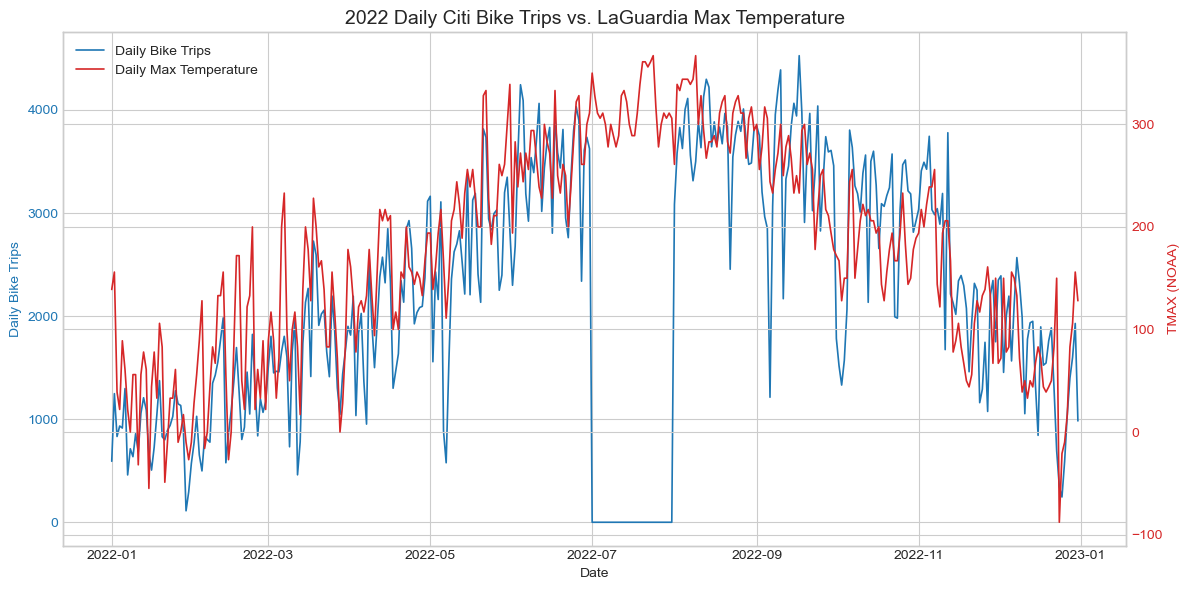

In [10]:
# 5. Dual-axis line chart: bike trips vs temperature

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot trips on primary y-axis
ax1.plot(df["date"], df["trips_daily"], label="Daily Bike Trips", linewidth=1.2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Bike Trips", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Twin axis for temperature
ax2 = ax1.twinx()
ax2.plot(df["date"], df["TMAX"], color="tab:red", label="Daily Max Temperature", linewidth=1.2)
ax2.set_ylabel("TMAX (NOAA)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout
plt.title("2022 Daily Citi Bike Trips vs. LaGuardia Max Temperature", fontsize=14)
fig.tight_layout()

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()

In [11]:
# Save figure
dual_fig_path = os.path.join(VIS_DIR, "trips_vs_temp_dual_axis.png")
fig.savefig(dual_fig_path)
plt.show()
print(f"Saved dual-axis plot to {dual_fig_path}")

Saved dual-axis plot to C:\Users\henry\OneDrive\citibike-dashboard-2022\Visualizations\trips_vs_temp_dual_axis.png



 6. Reflection / Explanation
 In this notebook, I used both the quick pandas plotting interface and the more precise
object-oriented Matplotlib API:
For the temperature time series, I used the **pandas wrapper** (`Series.plot`) which
 leverages Matplotlib under the hood for fast exploratory visualization.
 For the combined chart, I used the **object-oriented approach**: explicitly creating
  figure and axes objects (`fig, ax1 = plt.subplots()`), then adding a twin axis
 (`ax1.twinx()`) to handle differing scales (bike trips vs. temperature).
The OO API allows controlling each axis independently (labels, colors, ticks) and
 combining legends from both axes cleanly.

The chart is constructed from the outside in: figure → first axis → twin axis. This
follows Matplotlib’s hierarchy and ensures that all elements—titles, labels, and data— end up on the intended canvases.